In [1]:
import torch 
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

%cd ../

/workspace/Walk_Video_PyTorch/project


In [2]:
from models.pytorchvideo_models import WalkVideoClassificationLightningModule
from pytorch_lightning import Trainer

from IPython.display import clear_output

clear_output()

In [3]:
from pytorch_lightning import seed_everything

seed_everything(42, workers=True)

Global seed set to 42


42

In [4]:
from main import get_parameters

opt, unknown = get_parameters()
opt.num_workers = 8
opt.batch_size = 4
opt.gpu_num = 1

opt.version = '0821_2_16'
opt.model = "resnet"
opt.model_depth = 50
opt.model_class_num = 1

opt.clip_duraion = 1
opt.uniform_temporal_subsample_num = 16
opt.version = opt.version + '_' + opt.model + '_depth' + str(opt.model_depth)


In [5]:
from utils.utils import get_ckpt_path

model = WalkVideoClassificationLightningModule(opt)

# get last ckpt path
# ckpt_path = get_ckpt_path(opt)

ckpt_path = '/workspace/Walk_Video_PyTorch/logs/resnet/0904_1_32_resnet_depth50/checkpoints/epoch=32-val_loss=0.45-val_acc=0.8265.ckpt'

# model = WalkVideoClassificationLightningModule.load_from_checkpoint(ckpt_path)
# model.load_state_dict(weight)
model = model.load_from_checkpoint(ckpt_path)

model.eval()

# clear_output()
print(ckpt_path)


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


/workspace/Walk_Video_PyTorch/logs/resnet/0904_1_32_resnet_depth50/checkpoints/epoch=32-val_loss=0.45-val_acc=0.8265.ckpt


In [6]:
from dataloader.data_loader import WalkDataModule
from pytorch_lightning import loggers as pl_loggers 

# load test dataset 
module = WalkDataModule(opt)
module.setup()
test_data = module.test_dataloader()

# for the tensorboard
tb_logger = pl_loggers.TensorBoardLogger(save_dir="/workspace/Walk_Video_PyTorch/project/tests/logs", name=opt.model, version=opt.version)


In [7]:
import numpy as np 

from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
    GuidedGradCam,
)

from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms


from captum.attr import visualization as viz

torch.manual_seed(123)
np.random.seed(123)

/usr/local/lib/python3.9/dist-packages/captum/attr/_utils/visualization.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [8]:
batch = next(iter(test_data))

video = batch['video'].detach() # b, c, t, h, w
label = batch['label'].detach() # b, class num

video.shape, label.shape

(torch.Size([4, 3, 16, 224, 224]), torch.Size([4]))

In [9]:
# preds the video
with torch.no_grad():
    preds = model(video)

In [10]:
preds, label

(tensor([[ 1.4889],
         [-4.8758],
         [-2.4889],
         [ 1.0697]]),
 tensor([1, 0, 0, 1]))

In [11]:
torch.sigmoid(preds)

tensor([[0.8159],
        [0.0076],
        [0.0766],
        [0.7445]])

# Integrated Gradients 

In [12]:
# a series frame show 
def series_attr_show(attributions, raw_img, flag):
    '''
    show a series img where combine the raw img with the attr map.

    Args:
        attributions (tensor): attributions map, shape(b, c, f, h, w)
        raw_img (tensor): raw image, shape(b, c, f, h, w)
        flag (str): disease flag, choice [asd, asd_not]
    '''
    
    flag = flag.item()

    # to cpu and numpy
    attributions_ig = attributions.squeeze().cpu().detach().numpy() # c, f, h, w
    raw_img = raw_img.squeeze().cpu().detach().numpy() # c, f, h, w

    attr_ig_transpose = attributions_ig.transpose(1, 0, 2, 3) # f, c, h, w
    raw_img_transpose = raw_img.transpose(1, 0, 2, 3) # f, c, h, w

    f, c, h, w = attr_ig_transpose.shape

    for frame in range(f):

        now_attr_ig = attr_ig_transpose[frame].transpose(1, 2, 0) # h, w, c
        now_raw_img = raw_img_transpose[frame].transpose(1, 2, 0) # h, w, c

        # the attr map and raw img must have shape (h, w, c)
        figure, axis = viz.visualize_image_attr_multiple(now_attr_ig, 
                                now_raw_img,
                                methods=['original_image', 'blended_heat_map'],
                                signs=['all', 'all'],
                                show_colorbar=True,
                                outlier_perc=1, 
                                titles=['%s frame' % frame, 'attributions ig, label %s' % flag])


In [13]:
# define the gradient model
ig = IntegratedGradients(model.cuda())

input = video[0].unsqueeze(dim=0).cuda()

attributions_ig, delta = ig.attribute(input, target=0, return_convergence_delta=True, internal_batch_size=1)
attributions_ig.shape, delta

# show a series attr with raw img
series_attr_show(attributions_ig, input, flag=label[0])

RuntimeError: CUDA out of memory. Tried to allocate 14.00 MiB (GPU 0; 11.91 GiB total capacity; 1.14 GiB already allocated; 15.94 MiB free; 1.20 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# # default_cmap = LinearSegmentedColormap.from_list('custom blue', 
# #                                                  [(0, '#ffffff'),
# #                                                   (0.25, '#000000'),
# #                                                   (1, '#000000')], N=256)

# _ = viz.visualize_image_attr(attributions_ig_asd_not, 
#                              raw_img,
#                              method='blended_heat_map',
#                             #  cmap=default_cmap,
#                              show_colorbar=True,
#                              sign='all',
#                              outlier_perc=1, 
#                              title='attributions ig asd not ')

In [ ]:
# guided grad cam method
target_layer = model.model.blocks[-2].res_blocks[0].branch1_conv

In [ ]:
target_layer

Conv3d(1024, 2048, kernel_size=(1, 1, 1), stride=(1, 2, 2), bias=False)

/usr/local/lib/python3.9/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/captum/attr/_utils/visualization.py:234: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt_axis.grid(b=False)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IG Attributions: torch.Size([1, 3, 16, 224, 224])


/usr/local/lib/python3.9/dist-packages/captum/attr/_utils/visualization.py:44: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


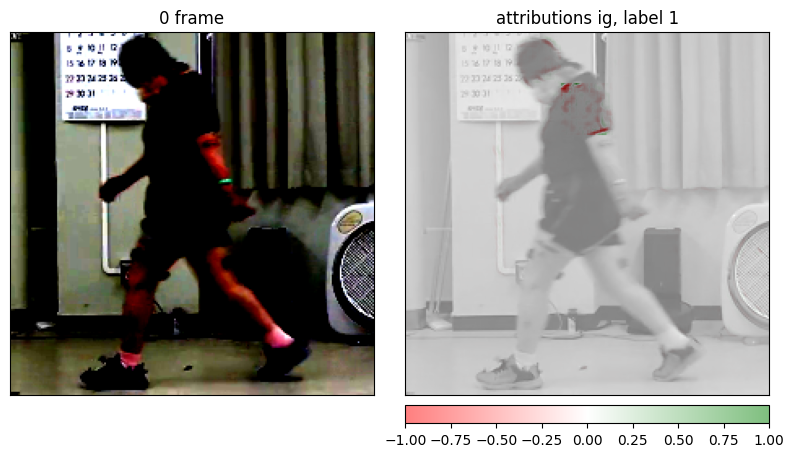

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


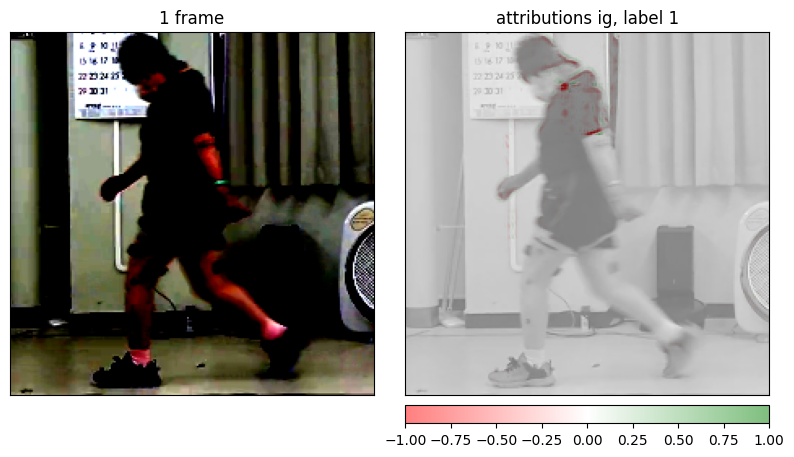

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


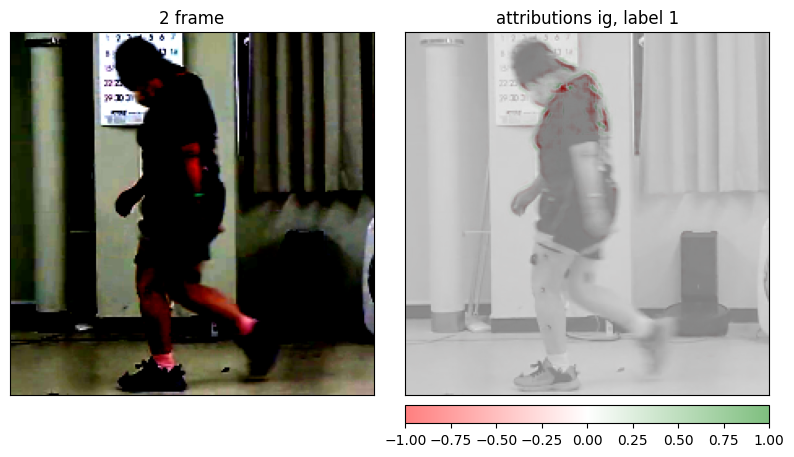

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


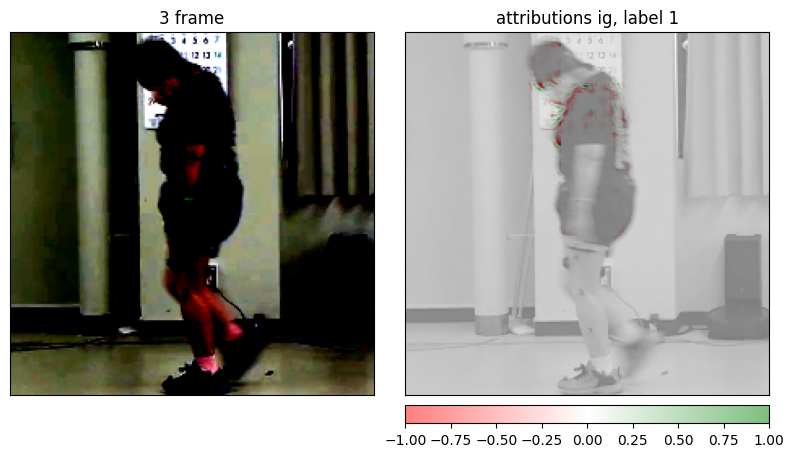

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


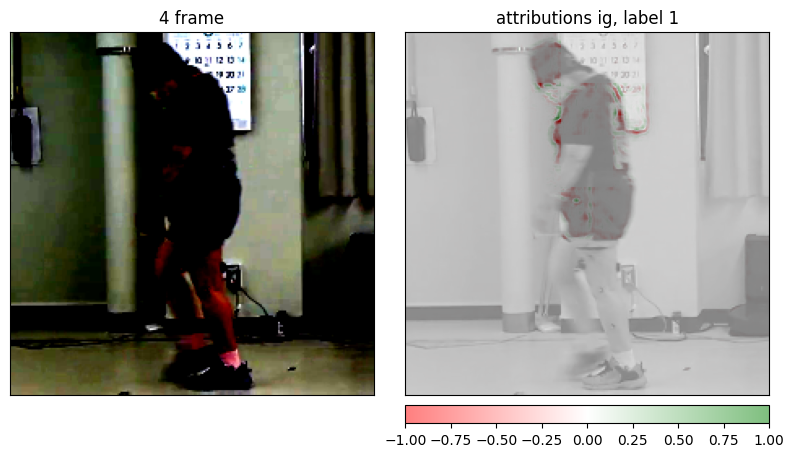

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


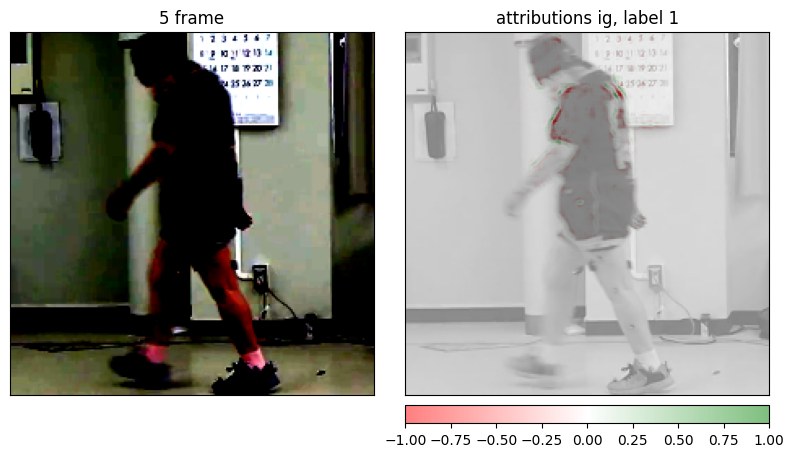

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


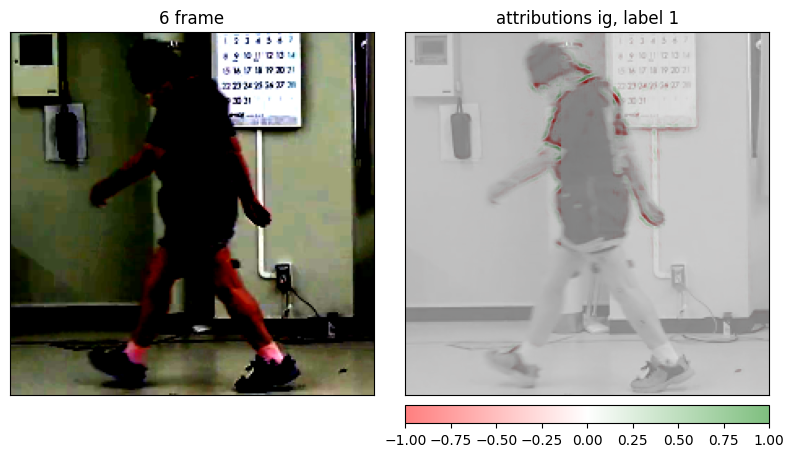

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


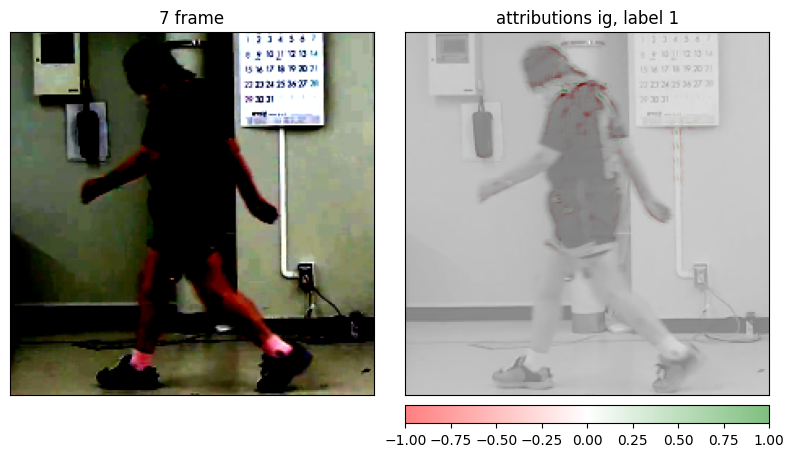

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


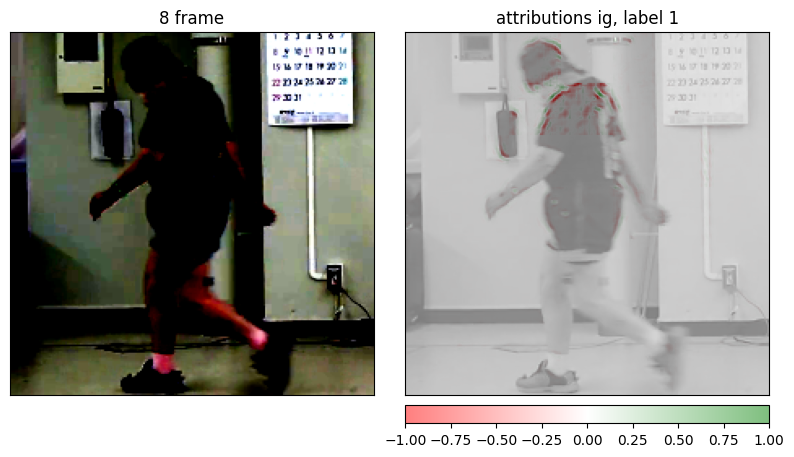

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


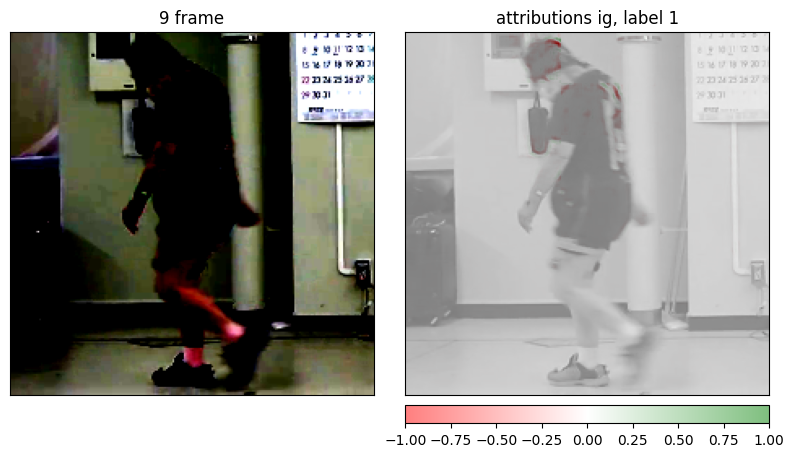

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


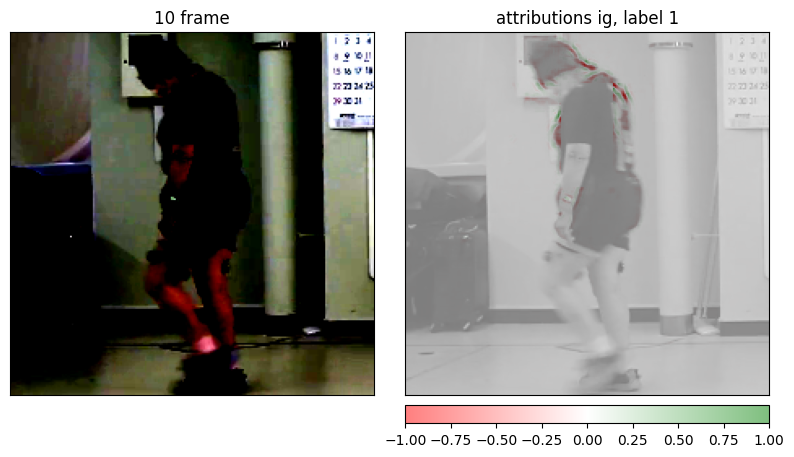

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


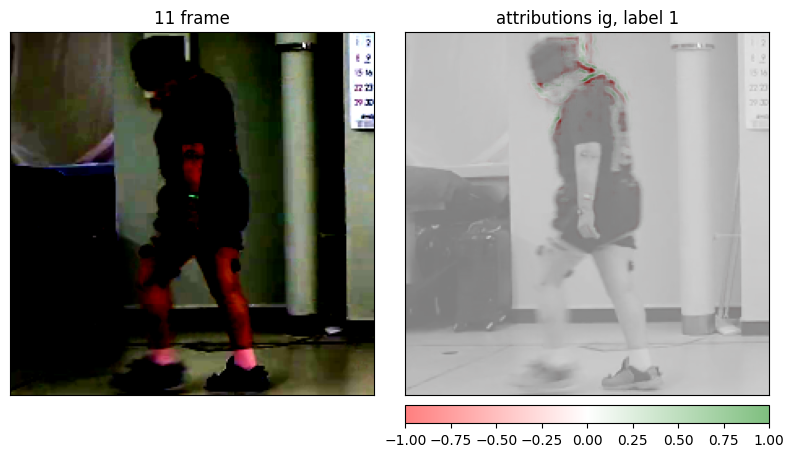

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


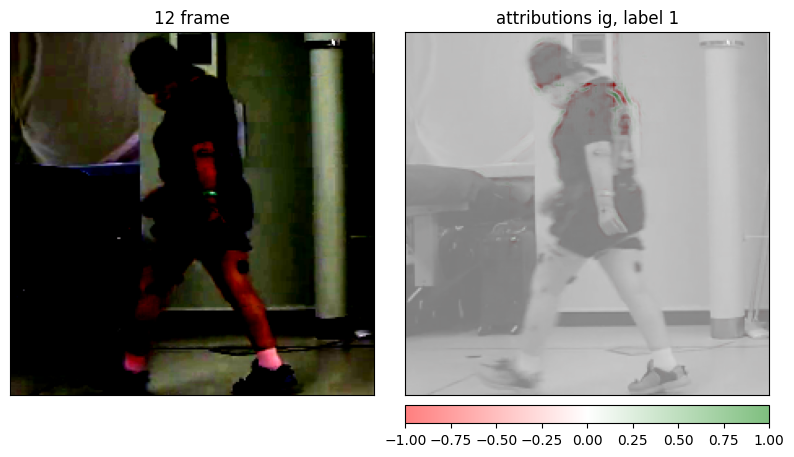

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


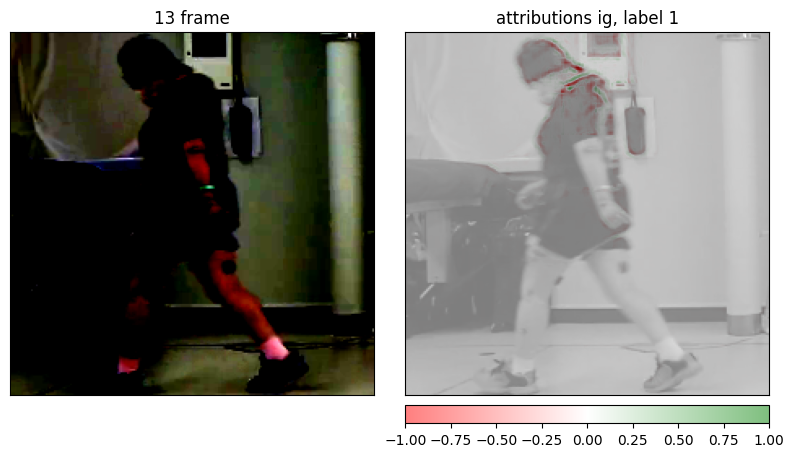

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


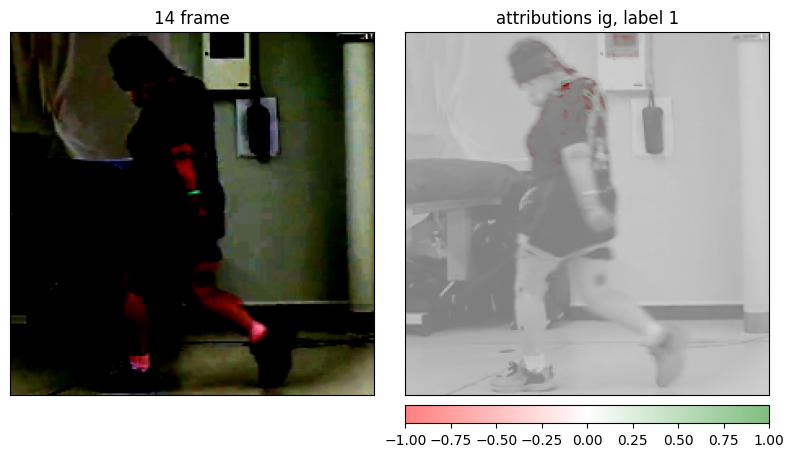

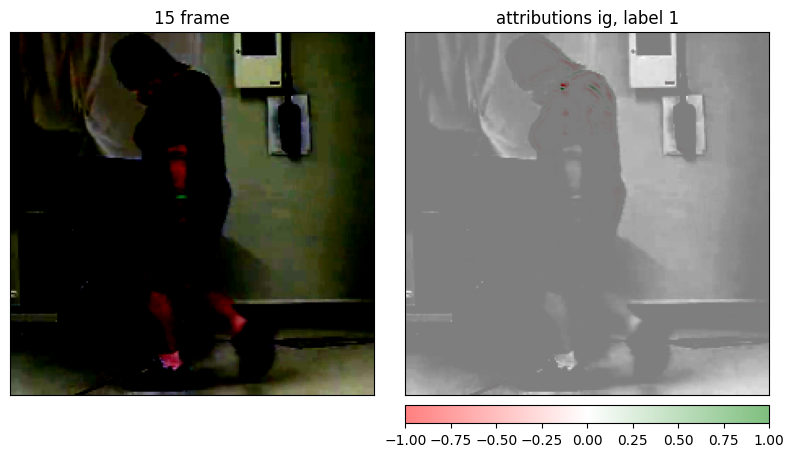

In [ ]:
guided_gc = GuidedGradCam(model.cuda(), target_layer)

input = video[0].unsqueeze(0).cuda()

attributions = guided_gc.attribute(input, target=0)

print('IG Attributions:', attributions.shape)

series_attr_show(attributions, input, flag=label[0])

In [ ]:
# deconvolution 
from captum.attr import Deconvolution

deconv = Deconvolution(model.cuda())

input = video[0].unsqueeze(0).cuda()

attributions = deconv.attribute(input, target=0)

In [ ]:
raw_img = video[0].squeeze().cpu().detach().numpy()
raw_img.shape

attributions_ig = attributions.squeeze().cpu().detach().numpy()
attributions_ig.shape

attributions_ig = attributions_ig.transpose(1, 0, 2, 3)[0].transpose(1, 2, 0)
raw_img = raw_img.transpose(1, 0, 2, 3)[0].transpose(1, 2, 0)
attributions_ig.shape, raw_img.shape

In [ ]:
figure, axis = viz.visualize_image_attr_multiple(attributions_ig, 
                             raw_img,
                             methods=['original_image', 'blended_heat_map'],
                             signs=['all', 'all'],
                             show_colorbar=True,
                             outlier_perc=1)

In [ ]:
# deep lift 
from captum.attr import DeepLift

dl = DeepLift(model.cuda())

input = video[0].unsqueeze(0).cuda()

attribution = dl.attribute(input, target=0)

In [ ]:
raw_img = video[0].squeeze().cpu().detach().numpy()
raw_img.shape

attributions_ig = attributions.squeeze().cpu().detach().numpy()
attributions_ig.shape

attributions_ig = attributions_ig.transpose(1, 0, 2, 3)[0].transpose(1, 2, 0)
raw_img = raw_img.transpose(1, 0, 2, 3)[0].transpose(1, 2, 0)
attributions_ig.shape, raw_img.shape

In [ ]:
figure, axis = viz.visualize_image_attr_multiple(attributions_ig, 
                             raw_img,
                             methods=['original_image', 'blended_heat_map'],
                             signs=['all', 'all'],
                             show_colorbar=True,
                             outlier_perc=1)

In [ ]:
# noise tunnel 
ig = IntegratedGradients(model.cuda())
noise_tunnel = NoiseTunnel(ig)

input = video[0].unsqueeze(0).cuda()

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=1, nt_type='smoothgrad_sq', target=0, nt_samples_batch_size=1)

RuntimeError: CUDA out of memory. Tried to allocate 2.39 GiB (GPU 0; 11.91 GiB total capacity; 8.42 GiB already allocated; 1.97 GiB free; 9.15 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
raw_img = video[0].squeeze().cpu().detach().numpy()
raw_img.shape

attributions_ig_nt = attributions_ig_nt.squeeze().cpu().detach().numpy()
attributions_ig_nt.shape

attributions_ig_nt = attributions_ig_nt.transpose(1, 0, 2, 3)[0].transpose(1, 2, 0)
raw_img = raw_img.transpose(1, 0, 2, 3)[0].transpose(1, 2, 0)
attributions_ig_nt.shape, raw_img.shape

In [ ]:
figure, axis = viz.visualize_image_attr_multiple(attributions_ig_nt, 
                             raw_img,
                             methods=['original_image', 'blended_heat_map'],
                             signs=['all', 'all'],
                             show_colorbar=True,
                             outlier_perc=1)

/usr/local/lib/python3.9/dist-packages/captum/attr/_utils/visualization.py:234: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt_axis.grid(b=False)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


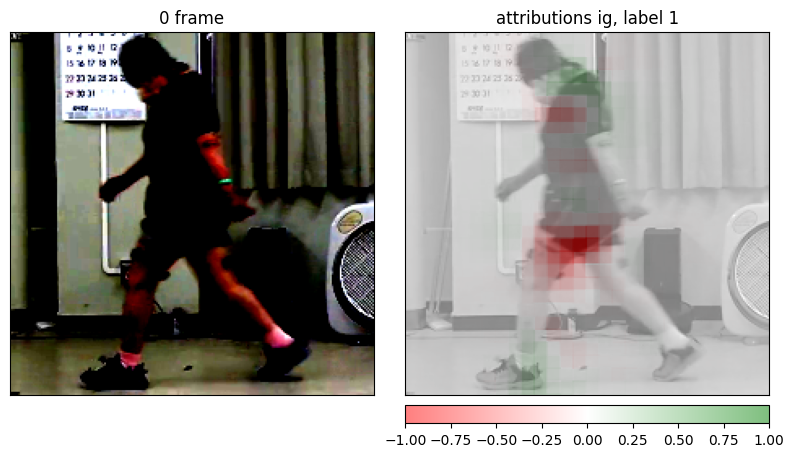

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


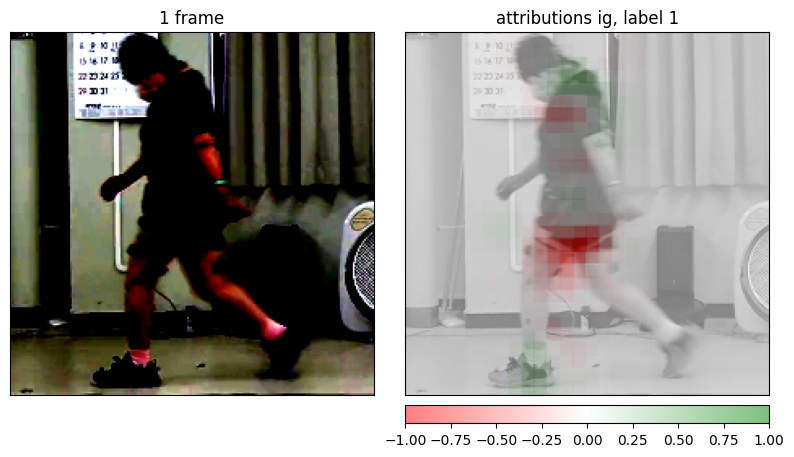

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


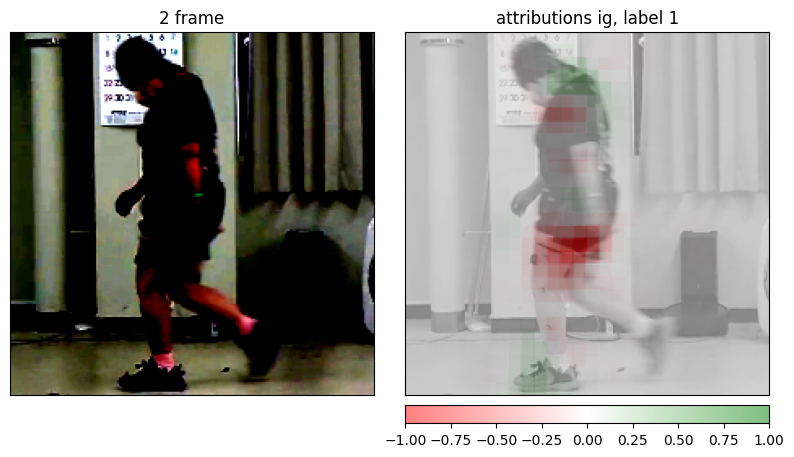

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


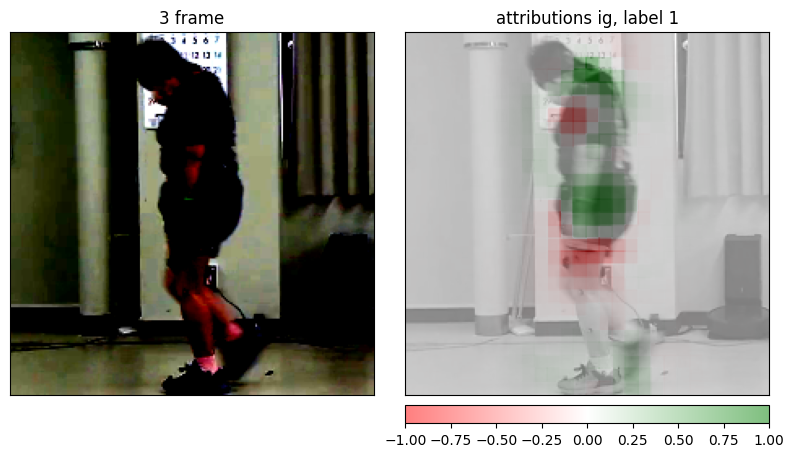

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


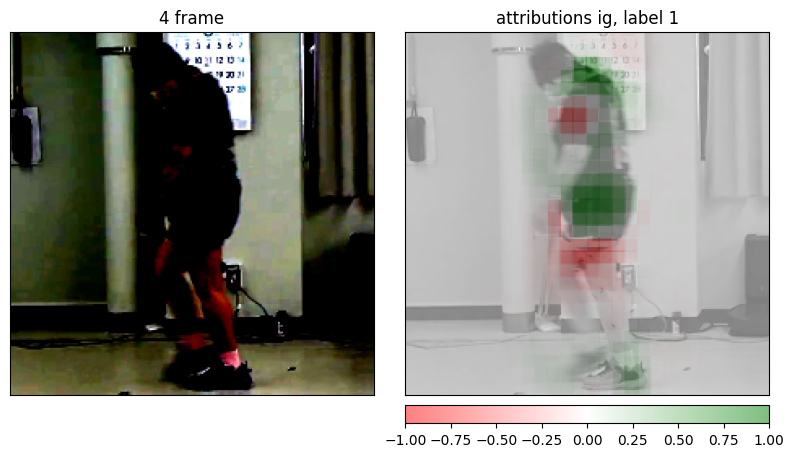

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


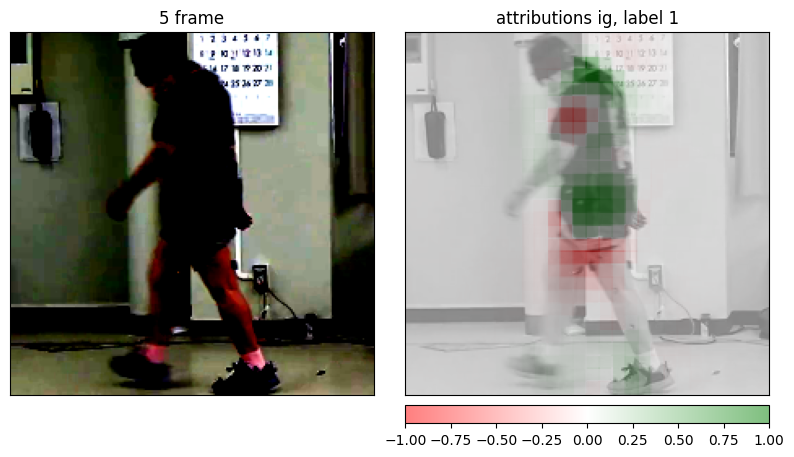

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


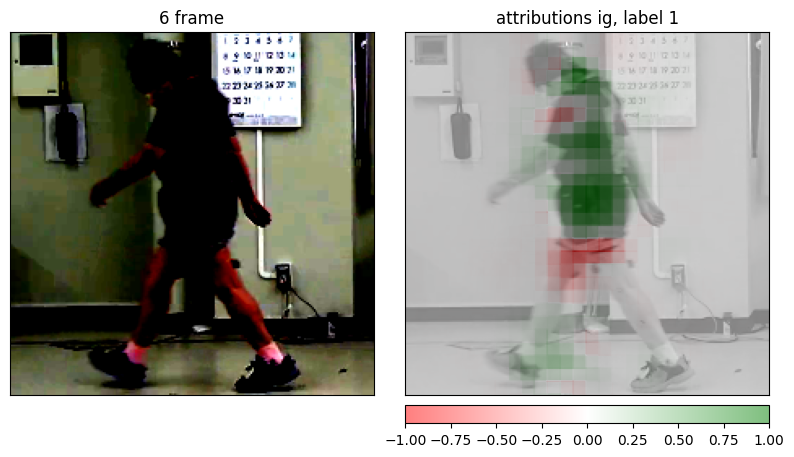

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


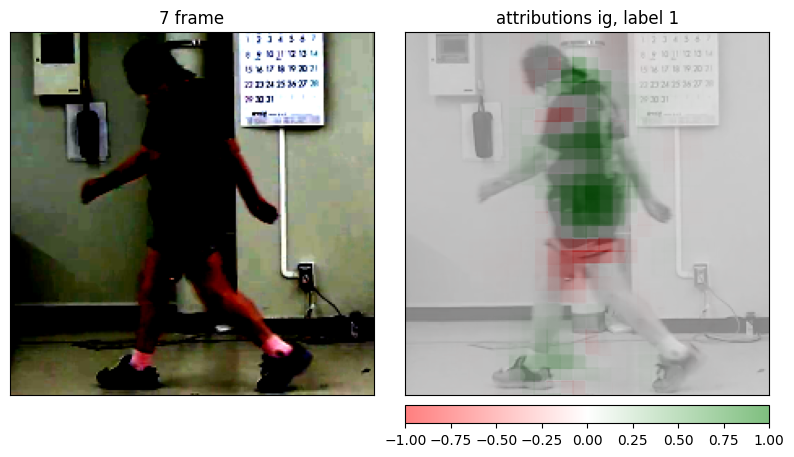

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


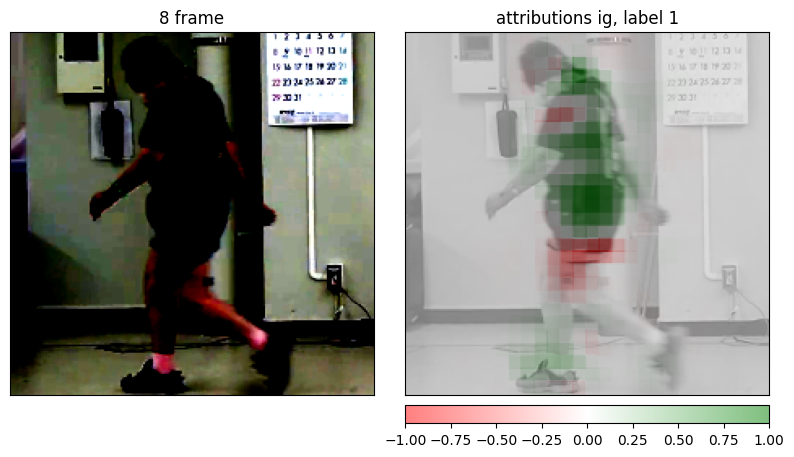

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


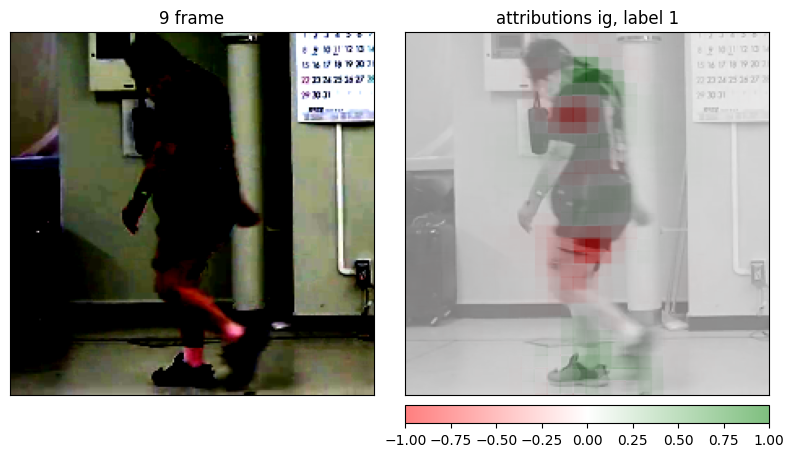

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


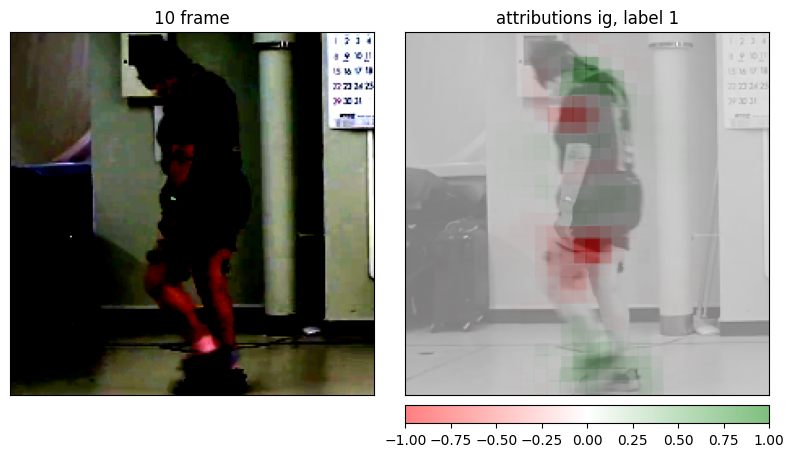

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


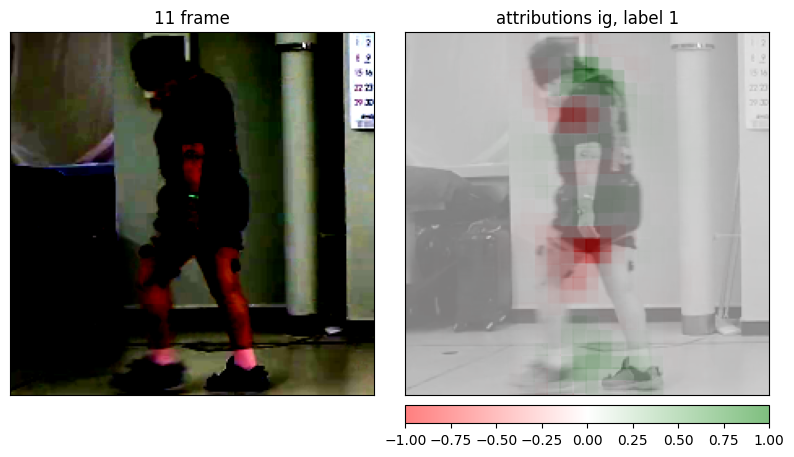

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


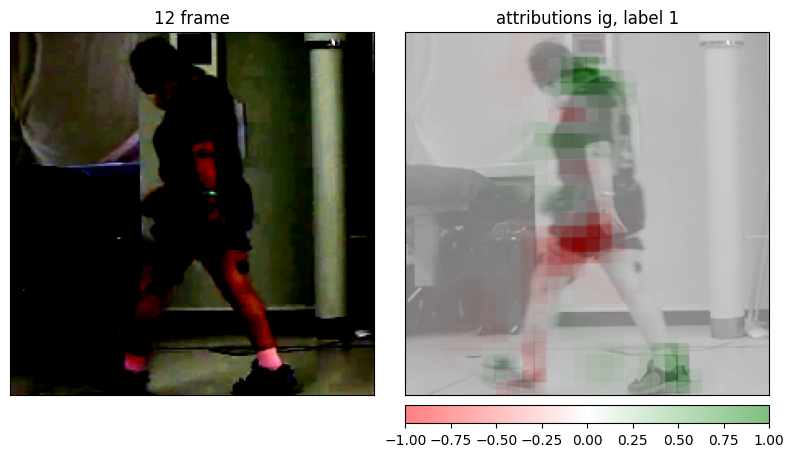

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


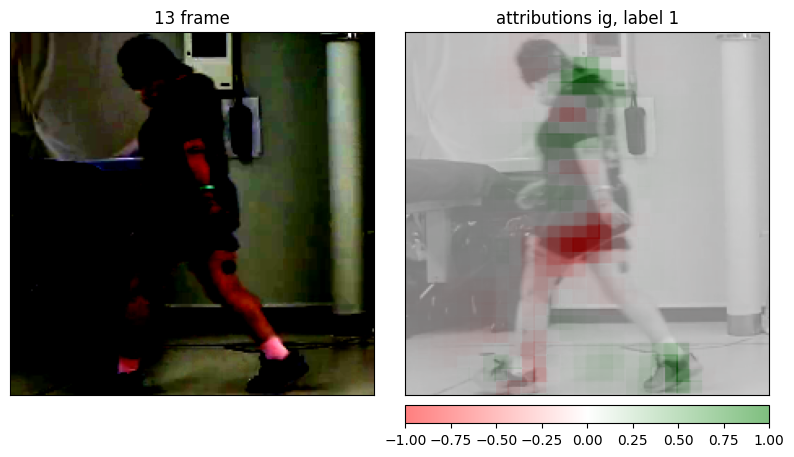

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


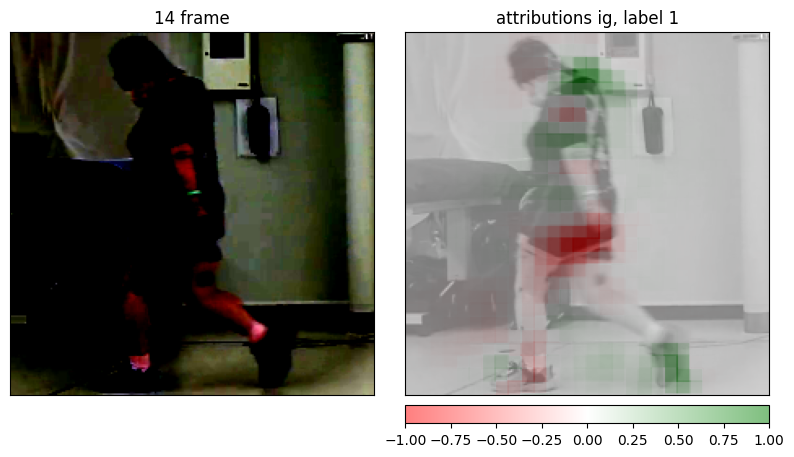

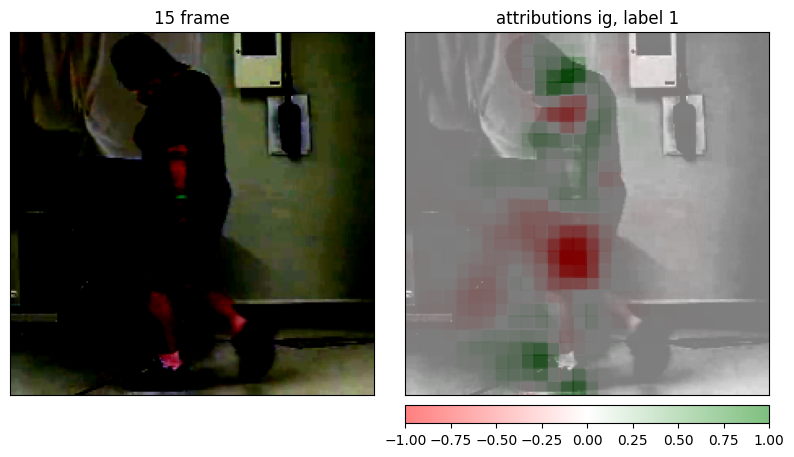

In [ ]:
# occlusion based attribution
from captum.attr import Occlusion

occlusion = Occlusion(model.cuda())

input = video[0].unsqueeze(0).cuda()

attributions_occ = occlusion.attribute(input,
                                       strides=(3, 3, 8, 8),
                                       target=0, sliding_window_shapes=(3, 3, 15, 15), baselines=0)

series_attr_show(attributions_occ, video[0], flag=label[0])